In [1]:
import sqlite3
import pandas as pd
import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.preprocessing.text import Tokenizer

print('ready')  

ready


In [2]:
conn = sqlite3.connect('C:\Python_Packages\ModelDev\database.sqlite3')

players are using different names, we need to have all those names associated with their ID
we have to remove brackets from names, because the matching does not work with them, python constraint
we sort them by lengt to match the longest names first, because if the shorter name is matched first, some part of names remain unmatched ("eric vs eric corona" become "123 vs 123 corona" instead of "123 vs 123") 

In [3]:
df_users = pd.read_sql_query("SELECT user_id, user_name FROM player_pickups WHERE pickup_name='6v6'", conn)
df_users = df_users.drop_duplicates(ignore_index=True)
df_users["user_id"] = df_users["user_id"].apply(str)
table = str.maketrans(dict.fromkeys("()"))
df_users["user_name"] = df_users["user_name"].str.translate(table)
df_users["length"] = df_users['user_name'].str.len()
df_users = df_users.sort_values(by=['length'], ascending=False, ignore_index=True)
pd.set_option('display.max_rows', None)

In [4]:
ids = dict(zip(df_users['user_name'],df_users['user_id']))

In [5]:
df = pd.read_sql_query("SELECT pickup_id, alpha_players, beta_players, winner_team FROM pickups WHERE pickup_name='6v6'", conn)

In [6]:
df_base = pd.read_sql_query("SELECT alpha_players FROM pickups WHERE pickup_name='6v6'and winner_team='alpha'", conn)
df_base['label'] = 'winner'

In [7]:
df_winner_beta = pd.read_sql_query("SELECT beta_players FROM pickups WHERE pickup_name='6v6'and winner_team='beta'", conn)
df_winner_beta['label'] = 'winner'

In [8]:
df_looser_alpha = pd.read_sql_query("SELECT alpha_players FROM pickups WHERE pickup_name='6v6'and winner_team='beta'", conn)
df_looser_alpha['label'] = 'looser'

In [9]:
df_looser_beta = pd.read_sql_query("SELECT beta_players FROM pickups WHERE pickup_name='6v6'and winner_team='alpha'", conn)
df_looser_beta['label'] = 'looser'

In [10]:
df_base.rename(columns={"alpha_players": "players"}, inplace = True)
df_winner_beta.rename(columns={"beta_players": "players"}, inplace = True)
df_looser_alpha.rename(columns={"alpha_players": "players"}, inplace = True)
df_looser_beta.rename(columns={"beta_players": "players"}, inplace = True)

In [11]:
df_abt = df_base.append([df_winner_beta, df_looser_alpha, df_looser_beta], ignore_index=True)
df_abt["players"] = df_abt["players"].str.translate(table)

In [12]:
df_abt['count'] = df_abt['players'].str.split().apply(len)           

In [13]:
df_abt['players_calc'] = df_abt['players'].replace(to_replace=ids, regex=True)
df_abt['count1'] = df_abt['players_calc'].str.split().apply(len)   
### df_abt.sort_values(by=['count1'])

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_abt['players_calc'])

word_idx = tokenizer.word_index
num_words = len(word_idx) + 1
word_counts = tokenizer.word_counts
sequences = tokenizer.texts_to_sequences(df_abt['players_calc'])
s = tokenizer.texts_to_sequences(df_abt['players_calc'])[0]
' '.join(tokenizer.index_word[i] for i in s)

print('\nNumber of Words: {}'.format(num_words))


Number of Words: 158


In [15]:
from keras.preprocessing.sequence import pad_sequences
data = pad_sequences(sequences, maxlen=6)
data.shape

Using TensorFlow backend.


(1380, 6)

In [16]:
tokenizer_label = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{}~\t\n')
tokenizer_label.fit_on_texts(df_abt['label'])

word_idx_lbl = tokenizer_label.word_index
num_words_lbl = len(word_idx_lbl) + 1
word_counts_lbl = tokenizer_label.word_counts
sequences_lbl = tokenizer_label.texts_to_sequences(df_abt['label']) 
s = tokenizer_label.texts_to_sequences(df_abt['label'])[0]
' '.join(tokenizer_label.index_word[i] for i in s)

print('\nWord Index : {}'.format(word_idx_lbl))
labels = pad_sequences(sequences_lbl, maxlen=1)
labels = labels-1


Word Index : {'winner': 1, 'looser': 2}


In [17]:
import numpy as np
labels = np.array(labels)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [18]:
num_validation_samples = int(0.2 * data.shape[0])
num_validation_samples

276

In [19]:
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [20]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional, Activation
from keras.optimizers import Adam
from keras.utils import plot_model

In [26]:
print('Building model...')
model1 = Sequential()
model1.add(Embedding(input_dim=num_words, output_dim=6, input_length=6))
model1.add(LSTM(24, dropout=0.3, recurrent_dropout=0.3))
model1.add(Dense(12, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

model1.summary()

Building model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 6, 6)              948       
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                2976      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 4,237
Trainable params: 4,237
Non-trainable params: 0
_________________________________________________________________


In [27]:
batch_size = 8

history = model1.fit(x_train, 
               y_train,
               batch_size=batch_size,
               epochs=100,
               verbose=1,
               validation_data=[x_val, y_val])

Train on 1104 samples, validate on 276 samples
Epoch 1/100
1104/1104 [==============================] - 1s 1ms/step - loss: 0.6932 - binary_accuracy: 0.5000 - val_loss: 0.6926 - val_binary_accuracy: 0.5471
Epoch 2/100
1104/1104 [==============================] - 1s 488us/step - loss: 0.6908 - binary_accuracy: 0.5679 - val_loss: 0.6888 - val_binary_accuracy: 0.5435
Epoch 3/100
1104/1104 [==============================] - 1s 487us/step - loss: 0.6704 - binary_accuracy: 0.6087 - val_loss: 0.6738 - val_binary_accuracy: 0.5616
Epoch 4/100
1104/1104 [==============================] - 1s 475us/step - loss: 0.6440 - binary_accuracy: 0.6368 - val_loss: 0.6780 - val_binary_accuracy: 0.5616
Epoch 5/100
1104/1104 [==============================] - 1s 530us/step - loss: 0.6354 - binary_accuracy: 0.6594 - val_loss: 0.6941 - val_binary_accuracy: 0.5616
Epoch 6/100
1104/1104 [==============================] - 1s 514us/step - loss: 0.6251 - binary_accuracy: 0.6803 - val_loss: 0.7023 - val_binary_accura

1104/1104 [==============================] - 1s 511us/step - loss: 0.5178 - binary_accuracy: 0.7337 - val_loss: 0.8532 - val_binary_accuracy: 0.5254
Epoch 52/100
1104/1104 [==============================] - 1s 506us/step - loss: 0.5239 - binary_accuracy: 0.7328 - val_loss: 0.8835 - val_binary_accuracy: 0.5254
Epoch 53/100
1104/1104 [==============================] - 1s 504us/step - loss: 0.5109 - binary_accuracy: 0.7437 - val_loss: 0.8361 - val_binary_accuracy: 0.5109
Epoch 54/100
1104/1104 [==============================] - 1s 456us/step - loss: 0.5210 - binary_accuracy: 0.7409 - val_loss: 0.8736 - val_binary_accuracy: 0.5145
Epoch 55/100
1104/1104 [==============================] - 0s 453us/step - loss: 0.5151 - binary_accuracy: 0.7373 - val_loss: 0.8952 - val_binary_accuracy: 0.5181
Epoch 56/100
1104/1104 [==============================] - 1s 457us/step - loss: 0.5145 - binary_accuracy: 0.7319 - val_loss: 0.8638 - val_binary_accuracy: 0.5072
Epoch 57/100
1104/1104 [=================

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


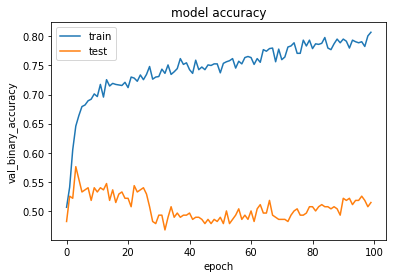

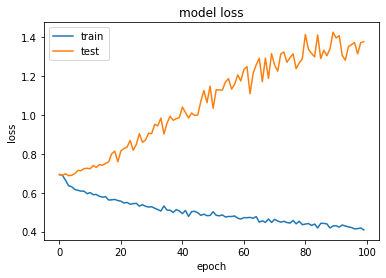

In [23]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('val_binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()